## Importing tools we are going to use for creating flakes/sheets.

In [27]:
from flowermd.base import Molecule
from flowermd.base import Pack, Simulation
import hoomd
import gsd.hoomd
#from flowermd.library import Graphene
import math
import numpy as np
from cmeutils.visualize import FresnelGSD
from flowermd.library.forcefields import BeadSpring
import mbuild as mb
from mbuild.compound import Compound
from mbuild.lattice import Lattice
from flowermd.base import Molecule, System

## In this example, I took flowermd's Graphene object and manipulated its geometry. How I did this was by setting the spacings, as in the space in between unit cells in any given direction, to 1.0 with a scalable variable multiplied by it. This way, it is very easy to visualize unit cells as well as complete lattices.

In [28]:
class Graphene(System):
    def __init__(
        self,
        x_repeat,
        y_repeat,
        n_layers,
        base_units=dict(),
        periodicity=(True, True, False),
    ):
        # creates an empty 'Compound' object to hold the graphene sheet with 'periodicity' defining whether the structure repeats in x,y,z
        surface = mb.Compound(periodicity=periodicity)
        scale = 1.732021616 # 1.0 for testing, 0.246 for graphene bond lengths
        spacings = [s * scale for s in [1.0, 1.0, 1.0]] # lattice spacing
        points = [[0, 0, 0], [2/3, 1/3, 0]] # unit cell points
        lattice = Lattice(
            lattice_spacing=spacings,
            angles=[90, 90, 120],
            lattice_points={"A": points},
        ) # angles between lattice vectors, 90-90-120 define a 2D hexagonal lattice extended into 3D.
        carbon = Compound(name="C", element="C") # defines a carbon atom that will be used to populate lattice points
        layers = lattice.populate(
            compound_dict={"A": carbon}, x=x_repeat, y=y_repeat, z=n_layers
        ) # populates the lattice using the previously defined carbon atom for every "A" site, repeated in all x,y, and z directions
        surface.add(layers) # adds populated carbon lattice layers to the 'surface' compound, which represents our graphene structure 
        surface.freud_generate_bonds("C", "C", dmin=0.3*scale, dmax=0.6*scale) # generates bonds depending on input distance range, scales with lattice
        surface_mol = Molecule(num_mols=1, compound=surface) # wraps into a Molecule object, creating "1" instance of this molecule

        super(Graphene, self).__init__(
            molecules=[surface_mol],
            base_units=base_units,
        )

    def _build_system(self):
        return self.all_molecules[0]

## Creating a system with a defined quantity of sheets/flakes

In [32]:
sheet = Graphene(x_repeat=5, y_repeat=5, n_layers=1, periodicity=(False, False, False)) # Creates a sheet, with inputs for xyz repeats of unit cells
# periodicity being "True" in any direction essentially makes the sheet infinitely repeating in that direction

In [33]:
# packs 5 copies of the sheet into a simulation box at a target density of 0.2
system = Pack(molecules= Molecule(compound=sheet.all_molecules[0], num_mols=1), density = 0.2)
# manually adjusting size of the box, commenting out is OK too as Pack automatically sets box size related to target density argument
system.hoomd_snapshot.configuration.box = [15, 15, 15, 0, 0, 0]

/home/eridanirojas/miniconda3/envs/flowermd/lib/python3.12/site-packages/mbuild/compound.py:547: UserWarning: Some particle of <Compound 50 particles, 61 bonds, System box: Box: Lx=8.660108, Ly=8.660108, Lz=1.732022, xy=-0.577350, xz=0.000000, yz=-0.577350, , id: 132576707915328> does not have a charge.They will not be accounted for during this calculation.
  warn(


In [34]:
system.visualize()

/home/eridanirojas/miniconda3/envs/flowermd/lib/python3.12/site-packages/mbuild/compound.py:547: UserWarning: Some particle of <Compound 50 particles, 61 bonds, System box: Box: Lx=8.541997, Ly=8.541997, Lz=8.541997, xy=0.000000, xz=0.000000, yz=0.000000, , id: 132573025860016> does not have a charge.They will not be accounted for during this calculation.
  warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## These blocks help us understand where we are at with bond lengths, number of atoms, molecules, etc.; are they what we expect them to be?

In [35]:
positions = system.hoomd_snapshot.particles.position

# Example: distance between particle 0 and 1
d = np.linalg.norm(positions[0] - positions[1])
print(f"Distance between particle 0 and 1: {d:.5f} nm")

Distance between particle 0 and 1: 1.73204 dimensionless nm


In [36]:
print(system.hoomd_snapshot.particles.position[0])
print(system.hoomd_snapshot.particles.position[1])
print(system.hoomd_snapshot.particles.position[2])
print(system.hoomd_snapshot.particles.position[3])

[-2.2918633 -3.2652457 -1.9516962] dimensionless
[-1.3916408 -3.4677567 -0.4859047] dimensionless
[-0.4914633 -3.6703072  0.9798067] dimensionless
[ 0.4087592 -3.8728183  2.4455981] dimensionless


In [28]:
np.linalg.norm(np.array(system.hoomd_snapshot.particles.position[0]) - np.array(system.hoomd_snapshot.particles.position[1]))

0.9999780212786428

In [29]:
np.linalg.norm(np.array(system.hoomd_snapshot.particles.position[2]) - np.array(system.hoomd_snapshot.particles.position[1]))

1.0000646249819303

In [30]:
np.linalg.norm(np.array(system.hoomd_snapshot.particles.position[3]) - np.array(system.hoomd_snapshot.particles.position[2]))

0.9999779231463118

In [31]:
np.linalg.norm(np.array(system.hoomd_snapshot.particles.position[3]) - np.array(system.hoomd_snapshot.particles.position[0]))

3.000020568574244

In [32]:
sheet.all_molecules[0]

<Compound 50 particles, 61 bonds, System box: Box: Lx=5.000000, Ly=5.000000, Lz=1.000000, xy=-0.577350, xz=0.000000, yz=-0.577350, , id: 140656305694928>

In [33]:
system.n_molecules

5

In [34]:
system.n_particles

250

In [35]:
snap = system.hoomd_snapshot
print(snap.particles.types)
print(snap.bonds.types)
print(snap.angles.types)
print(snap.dihedrals.types)

['C']
['C-C']
['C-C-C']
['C-C-C-C']


## Forcefield defines how these sheets interact amongst themselves as well as with other sheets. "beads" represents interactions with other particles it is not bonded to, "bonds" define the equilibrium bond length for bonded particles, "angles" defines the equilibrium angle between three bonded particles, and "dihedrals" defines the equilibrium torsion angle between 4 bonded particles. k is a stiffness constant associated with every bonded interactions, ensuring structural rigidity.

In [36]:
s = 1.0 # 1.0 for scaling

In [37]:
ff = BeadSpring(
    r_cut=2.5,  # cutoff distance for non-bonded interactions, for "beads"
    beads={
        "C": dict(epsilon=0.1, sigma=1.0)
        # non-bonded Lennard-Jones parameters for carbon beads:
        # epsilon: depth of the potential well (interaction strength)
        # sigma: finite distance at which the potential is zero (bead size)
    },
    bonds={
        "C-C": dict(r0=0.57736*s, k=500)
        # harmonic bond potential between bonded carbon atoms:
        # r0: equilibrium bond length (scaled by s)
        # k: bond stiffness (force constant)
    },
    angles={
        "C-C-C": dict(t0=2*np.pi/3, k=500)
        # harmonic angle potential between three bonded carbons:
        # t0: equilibrium bond angle (120° for sp2 bonding)
        # k: angular stiffness
    },
    dihedrals={
        "C-C-C-C": dict(phi0=0.1, k=500, d=1, n=1)
        # dihedral potential (torsion) for four bonded carbons:
        # phi0: equilibrium dihedral angle (in radians)
        # k: torsional stiffness
        # d: phase shift direction (±1)
        # n: periodicity (number of minima per 2π)
    }
)

In [38]:
print(len(system.hoomd_snapshot.dihedrals.types))
print(len(system.hoomd_snapshot.dihedrals.group))

1
880


## Running an NVT simulation, holding number of molecules, volume, and temperature constant.

In [39]:
del sim # reset simulation, if sim already exists

NameError: name 'sim' is not defined

In [22]:
cpu = hoomd.device.CPU() # setting our device in which to run the simulation on 

In [23]:
sim = Simulation(initial_state=system.hoomd_snapshot, forcefield=ff.hoomd_forces, device = cpu,
                 gsd_write_freq=int(1000), gsd_file_name="single_sheet.gsd")
# feeding our system as the initial state, our created forcefield, our device, a writing frequency for the output trajectory file as well as an output
# file name.

Initializing simulation state from a gsd.hoomd.Frame.


In [25]:
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0) # give some initial velocities; temperature is an atomic speedometer

In [27]:
sim.run_NVT(n_steps=2e5,kT=1.0, tau_kt = 0.1) # kT = temperature, tau_kT = thermostat coupling time, how often temperature is corrected during run.
sim.flush_writers() # flushing data to gsd file (even log files if asked for)

Step 1000 of 200000; TPS: 1927.91; ETA: 1.7 minutes
Step 2000 of 200000; TPS: 2835.46; ETA: 1.2 minutes
Step 3000 of 200000; TPS: 3351.37; ETA: 1.0 minutes
Step 4000 of 200000; TPS: 3691.27; ETA: 0.9 minutes
Step 5000 of 200000; TPS: 3898.49; ETA: 0.8 minutes
Step 6000 of 200000; TPS: 4053.42; ETA: 0.8 minutes
Step 7000 of 200000; TPS: 4187.65; ETA: 0.8 minutes
Step 8000 of 200000; TPS: 4227.65; ETA: 0.8 minutes
Step 9000 of 200000; TPS: 4300.58; ETA: 0.7 minutes
Step 10000 of 200000; TPS: 4365.79; ETA: 0.7 minutes
Step 11000 of 200000; TPS: 4389.94; ETA: 0.7 minutes
Step 12000 of 200000; TPS: 4443.23; ETA: 0.7 minutes
Step 13000 of 200000; TPS: 4490.36; ETA: 0.7 minutes
Step 14000 of 200000; TPS: 4531.23; ETA: 0.7 minutes
Step 15000 of 200000; TPS: 4514.62; ETA: 0.7 minutes
Step 16000 of 200000; TPS: 4527.94; ETA: 0.7 minutes
Step 17000 of 200000; TPS: 4553.11; ETA: 0.7 minutes
Step 18000 of 200000; TPS: 4566.95; ETA: 0.7 minutes
Step 19000 of 200000; TPS: 4586.22; ETA: 0.7 minutes
St

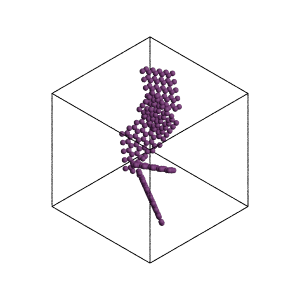

In [28]:
sim_visualizer = FresnelGSD(gsd_file="single_sheet.gsd", frame=1, view_axis=(1, 1, 1))
sim_visualizer.view()